In [1]:
import torch
import itertools

import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from copy import deepcopy
from collections import Counter
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import NullFormatter

In [2]:
# Reconstruct the model
def model_builder(N, m, k, nonlinearity):
    if nonlinearity == 'ReLU':
        activation = nn.ReLU()
    elif nonlinearity == 'GeLU':
        activation = nn.GELU()
    elif nonlinearity == 'SoLU':
        activation = lambda x: x*torch.exp(x)    
    
    model = torch.nn.Sequential(
                nn.Linear(m, k, bias=True),
                activation,
                nn.Linear(k, N, bias=False)
            )
    return model

# Model output +ve/-ve bias decomposition following Jermyn et al.

In [3]:
model = 'model3'
# model='soft_dot_penalised_model'
k = 1024 # size of nonlinear layer
log2_batch_size = 13
log2_training_steps = 18
sample_kind = 'equal'
init_bias = 0.0
nonlinearity = 'ReLU'
task = 'autoencoder'
decay = 0.0
eps = 0.015625
m = 64 # input dimensions
N = 512 # number of features
reg = 0.0
# lr = 0.001

In [4]:
names = list([
    f"../my_models/{model}_{task}_{nonlinearity}_k_{k}_batch_{log2_batch_size}_steps_{log2_training_steps}_learning_rate_{lr}_sample_{sample_kind}_init_bias_{init_bias}_decay_{decay}_eps_{eps}_m_{m}_N_{N}_reg_{reg}.pt"
    for lr in [0.001,0.003,0.005,0.007,0.01,0.03]])

In [5]:
batch = torch.load(names[-1], map_location=torch.device('cpu'))

In [6]:
batch.keys()

dict_keys(['k', 'log2_batch_size', 'log2_training_steps', 'learning_rate', 'sample_kind', 'initial_bias', 'nonlinearity', 'losses', 'final_model', 'log2_spaced_models', 'setup', 'task', 'decay', 'eps', 'm', 'N', 'reg'])

In [7]:
fixed_embedder = batch['setup']['fixed_embedder']

In [8]:
d = batch['log2_spaced_models'][-1]
print(d['2.weight'].shape[0], N)
print(d['0.weight'].shape[1], m)
print(d['0.weight'].shape[0], k)
model = model_builder(d['2.weight'].shape[0], d['0.weight'].shape[1], d['0.weight'].shape[0], nonlinearity)
model.load_state_dict(batch['log2_spaced_models'][-1])
model.to('cpu')

512 512
64 64
1024 1024


Sequential(
  (0): Linear(in_features=64, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=512, bias=False)
)

In [9]:
print(d.keys())
print(d['0.bias'])
print(d['0.bias'].shape)

odict_keys(['0.weight', '0.bias', '2.weight'])
tensor([-0.1092, -0.0671, -0.0628,  ..., -0.6366, -0.5763, -0.6240])
torch.Size([1024])


In [10]:
where_neg_bias = np.where(d['0.bias'].detach().numpy() < 0.0)[0]
# print(where_neg_bias)
where_pos_bias = np.where(d['0.bias'].detach().numpy() >= 0.0)[0]
# print(where_pos_bias)

neg_d = deepcopy(batch['log2_spaced_models'][-1])
print(neg_d['0.weight'][where_pos_bias, :])
print(neg_d['0.weight'][where_pos_bias, :].shape)

neg_d['0.weight'][where_pos_bias, :] *= 0
neg_d['0.bias'][where_pos_bias] *= 0
neg_model = model_builder(neg_d['2.weight'].shape[0], neg_d['0.weight'].shape[1], neg_d['0.weight'].shape[0], nonlinearity)
neg_model.load_state_dict(neg_d)
neg_model.to('cpu')

pos_d = deepcopy(batch['log2_spaced_models'][-1])
print(pos_d['0.weight'][where_neg_bias, :])
print(pos_d['0.weight'][where_neg_bias, :].shape)
pos_d['0.weight'][where_neg_bias, :] *= 0
pos_d['0.bias'][where_neg_bias] *= 0
pos_model = model_builder(d['2.weight'].shape[0], d['0.weight'].shape[1], d['0.weight'].shape[0], nonlinearity)
pos_model.load_state_dict(pos_d)
pos_model.to('cpu')

tensor([[ 0.0149,  0.0229, -0.0499,  ..., -0.0177,  0.0037, -0.0515],
        [-0.0165, -0.0225,  0.0224,  ..., -0.0095,  0.0381, -0.0469],
        [ 0.0464, -0.0211, -0.0270,  ...,  0.0034,  0.0224, -0.0086],
        ...,
        [-0.0030,  0.0187, -0.0002,  ...,  0.0176,  0.0765, -0.0026],
        [ 0.0098, -0.0387, -0.0221,  ...,  0.0724, -0.0226, -0.0556],
        [-0.0499,  0.0139,  0.0328,  ..., -0.0598,  0.0096, -0.0360]])
torch.Size([85, 64])
tensor([[ 0.0044, -0.0325,  0.0558,  ...,  0.0008, -0.0616,  0.0332],
        [-0.0326,  0.0265, -0.0068,  ..., -0.0342, -0.0283,  0.1295],
        [-0.0237, -0.0275,  0.0311,  ..., -0.0125, -0.0302,  0.1322],
        ...,
        [-0.0730, -0.2727, -0.2179,  ...,  0.0385, -0.0278,  0.0410],
        [ 0.1557,  0.1714,  0.1017,  ..., -0.1392, -0.3834,  0.1252],
        [-0.1550, -0.2040, -0.1682,  ..., -0.0497, -0.3455,  0.0975]])
torch.Size([939, 64])


Sequential(
  (0): Linear(in_features=64, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=512, bias=False)
)

In [11]:
full_os = []
neg_os = []
pos_os = []
step_size = .01
for a in np.arange(0, 1 + step_size, step_size):
    vs = torch.eye(N) * a
    ins = torch.matmul(vs, fixed_embedder.T)
    full_os.append(model.forward(ins).T.detach().numpy())
    neg_os.append(neg_model.forward(ins).T.detach().numpy())
    pos_os.append(pos_model.forward(ins).T.detach().numpy())

In [12]:
neg_os[0].shape

(512, 512)

In [13]:
f = []
n = []
p = []
j = 200
for i in range(len(neg_os)):
    f.append(full_os[i][j,j])
    n.append(neg_os[i][j,j])
    p.append(pos_os[i][j,j])

In [14]:
print(n)

[0.0, 0.0, -2.5441793e-07, -5.9314794e-07, -4.202111e-07, 3.0180104e-07, 1.0238127e-06, 1.7458265e-06, 4.002368e-06, 2.6284528e-05, 4.8566686e-05, 7.084883e-05, 9.313094e-05, 0.00012184156, 0.00021331574, 0.00030478992, 0.0003962638, 0.00048773768, 0.0006213086, 0.0007794164, 0.00093752454, 0.0010956328, 0.0012537414, 0.0014118503, 0.0015699584, 0.001788395, 0.0020467264, 0.0023265076, 0.0026081726, 0.0028898364, 0.003186516, 0.0034843613, 0.003782209, 0.0040800553, 0.0043779016, 0.004677956, 0.004990059, 0.008247912, 0.021508481, 0.03476906, 0.048029702, 0.061291695, 0.07455373, 0.08781578, 0.10108265, 0.11439136, 0.12770005, 0.14100873, 0.15431733, 0.16762593, 0.18093471, 0.19425319, 0.20763491, 0.22103572, 0.23444507, 0.24786459, 0.26128778, 0.27471095, 0.2881341, 0.30155724, 0.31498072, 0.3284038, 0.3418269, 0.35525015, 0.36867324, 0.38209632, 0.39551952, 0.40894303, 0.42236713, 0.43579155, 0.44921562, 0.46263993, 0.47606444, 0.48948863, 0.5029194, 0.5163518, 0.52978146, 0.54320544

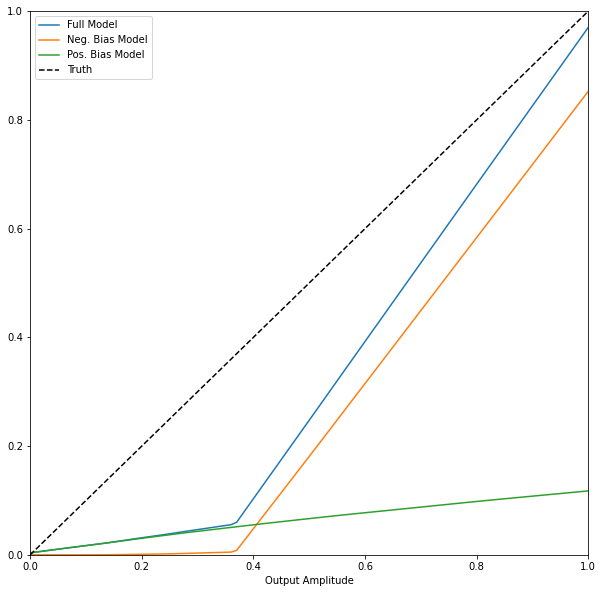

In [15]:
plt.figure(figsize=(10,10))
plt.plot(np.arange(0, 1 + step_size, step_size), f, '-', label='Full Model')
plt.plot(np.arange(0, 1 + step_size, step_size), n, '-', label='Neg. Bias Model')
plt.plot(np.arange(0, 1 + step_size, step_size), p, '-', label='Pos. Bias Model')
plt.plot([0,1], [0,1], 'k--', label='Truth')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Input Feature Amplitude')
plt.xlabel('Output Amplitude')
plt.legend()
plt.show()

During training inputs are in [0,1]. At test time anything outside this is out of distribution.

# How many different features does a neuron fire for?

In [16]:
vs = torch.eye(N)
ins = torch.matmul(vs, fixed_embedder.T)
sfa = model[:2].forward(ins).T.detach().numpy()
unit_sfa = np.array(sfa > 0.0, dtype='int')

In [17]:
unit_sfa

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [18]:
unit_sfa.shape

(1024, 512)

In [19]:
np.sum(unit_sfa, axis=-1)

array([ 7, 28, 33, ...,  1,  1,  1])

In [20]:
np.sum(unit_sfa, axis=-1).shape

(1024,)

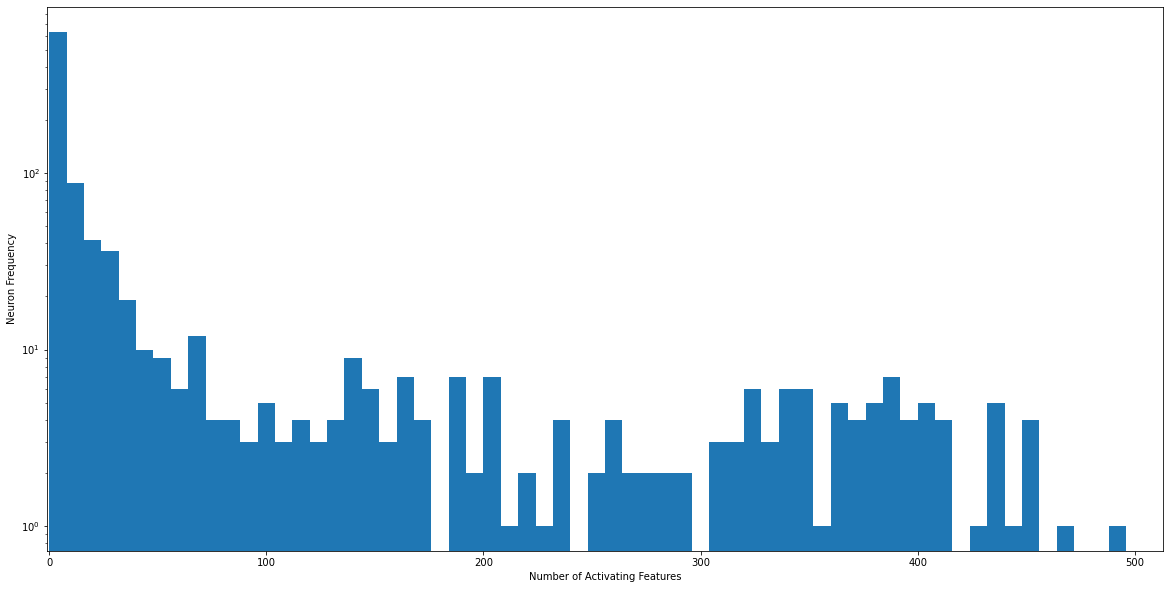

In [21]:
bins = range(0,N+8,8)
plt.figure(figsize=(20,10))
counts, _, _ = plt.hist(np.sum(unit_sfa, axis=-1), bins=bins)
plt.yscale('log')
plt.xlabel('Number of Activating Features')
plt.ylabel('Neuron Frequency')
plt.xlim(-1,513)
plt.show()

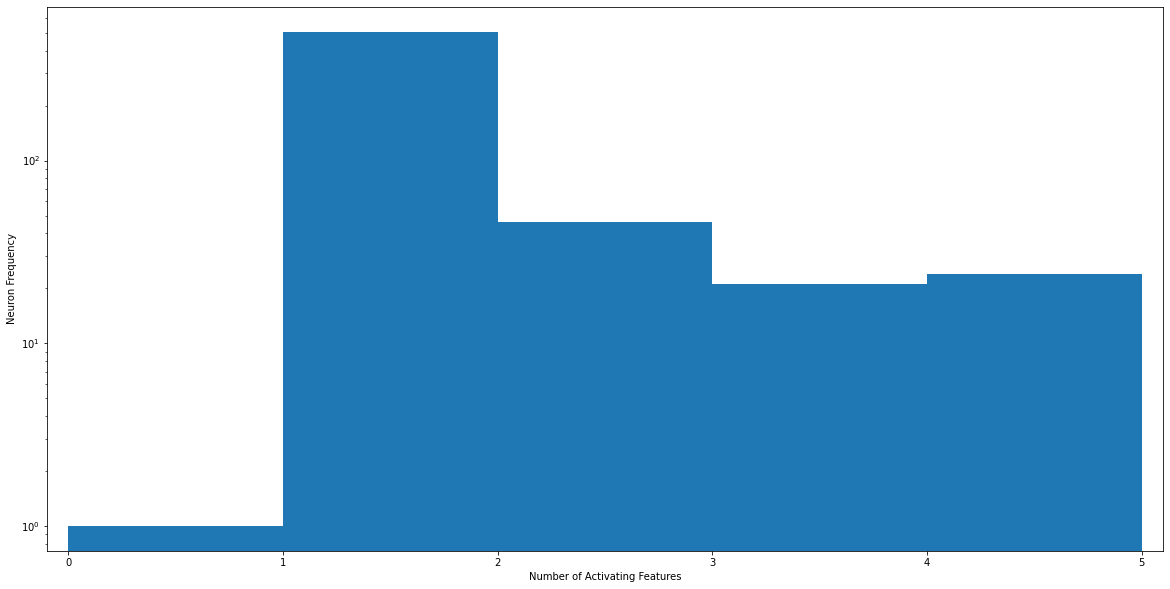

In [22]:
bins = range(0,6,1)
plt.figure(figsize=(20,10))
counts, _, _ = plt.hist(np.sum(unit_sfa, axis=-1), bins=bins)
plt.yscale('log')
plt.xlabel('Number of Activating Features')
plt.ylabel('Neuron Frequency')
plt.xlim(-.1,5.1)
plt.show()

In [23]:
counts[:3]

array([  1., 506.,  46.])

In [24]:
np.sum(counts[2:])

91.0

In [25]:
12+617+395

1024

The plot shows how many neurons (y-axis) fire for how many features. The first bin shows that 12 neurons fire for no features (dead neurons). The second shows 617 fire for 1 neuron (monosemantic) and 395 fire for more than one feature (polysemantic).

In [26]:
counts = Counter(np.sum(unit_sfa, axis=-1))

In [27]:
counts

Counter({7: 16,
         28: 6,
         33: 6,
         1: 506,
         18: 7,
         87: 1,
         407: 1,
         340: 3,
         12: 10,
         3: 21,
         190: 1,
         39: 2,
         2: 46,
         10: 19,
         439: 2,
         184: 1,
         25: 5,
         5: 8,
         194: 1,
         169: 1,
         119: 2,
         262: 1,
         465: 1,
         8: 11,
         378: 1,
         6: 16,
         19: 6,
         188: 2,
         205: 1,
         388: 1,
         275: 1,
         29: 2,
         68: 2,
         64: 3,
         127: 1,
         4: 16,
         371: 1,
         26: 8,
         414: 1,
         11: 9,
         23: 5,
         38: 1,
         239: 1,
         36: 3,
         189: 1,
         35: 2,
         344: 2,
         13: 10,
         294: 1,
         133: 1,
         319: 1,
         427: 1,
         14: 11,
         376: 2,
         391: 2,
         161: 1,
         50: 2,
         164: 1,
         9: 9,
         278: 1,
       

In [28]:
c = [np.sum([counts[k] for k in counts if k not in [0,1] ]), counts[1], counts[0]]

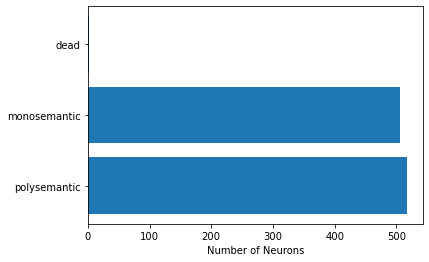

In [29]:
y_pos = range(0,3,1)
plt.barh(y_pos, c)
plt.xlabel('Number of Neurons')
plt.yticks(y_pos, ['polysemantic', 'monosemantic', 'dead'])
plt.show()

# Model output neuron-activation count decomposition 

In [30]:
where_mono = np.where(np.sum(unit_sfa, axis=-1) == 1)[0]
where_poly = np.where(np.sum(unit_sfa, axis=-1) > 1)[0]

mono_d = deepcopy(batch['log2_spaced_models'][-1])
print(mono_d['0.weight'][where_poly, :])
print(mono_d['0.weight'][where_poly, :].shape)

mono_d['0.weight'][where_poly, :] *= 0
mono_d['0.bias'][where_poly] *= 0
mono_model = model_builder(d['2.weight'].shape[0], d['0.weight'].shape[1], d['0.weight'].shape[0], nonlinearity)
mono_model.load_state_dict(mono_d)
mono_model.to('cpu')

poly_d = deepcopy(batch['log2_spaced_models'][-1])
# print(poly_d['0.weight'][where_mono, :])
# print(poly_d['0.weight'][where_mono, :].shape)
poly_d['0.weight'][where_mono, :] *= 0
poly_d['0.bias'][where_mono] *= 0
poly_model = model_builder(d['2.weight'].shape[0], d['0.weight'].shape[1], d['0.weight'].shape[0], nonlinearity)
poly_model.load_state_dict(poly_d)
poly_model.to('cpu')

tensor([[ 0.0044, -0.0325,  0.0558,  ...,  0.0008, -0.0616,  0.0332],
        [-0.0326,  0.0265, -0.0068,  ..., -0.0342, -0.0283,  0.1295],
        [-0.0237, -0.0275,  0.0311,  ..., -0.0125, -0.0302,  0.1322],
        ...,
        [-0.0132, -0.0357,  0.0072,  ..., -0.0002,  0.0487, -0.0279],
        [-0.0743,  0.0677, -0.0682,  ..., -0.0480,  0.0703,  0.0310],
        [ 0.0281, -0.0253,  0.0104,  ...,  0.0132,  0.0507,  0.0538]])
torch.Size([517, 64])


Sequential(
  (0): Linear(in_features=64, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=512, bias=False)
)

In [31]:
mono_os = []
poly_os = []
for a in np.arange(0, 1 + step_size, step_size):
    vs = torch.eye(N) * a
    ins = torch.matmul(vs, fixed_embedder.T)
    mono_os.append(mono_model.forward(ins).T.detach().numpy())
    poly_os.append(poly_model.forward(ins).T.detach().numpy())

In [32]:
mono = []
poly = []
for i in range(len(mono_os)):
    mono.append(mono_os[i][j,j])
    poly.append(poly_os[i][j,j])

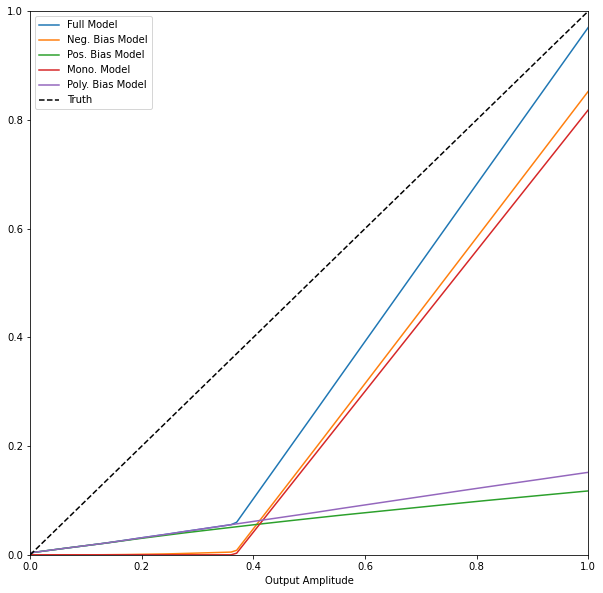

In [33]:
plt.figure(figsize=(10,10))
plt.plot(np.arange(0, 1 + step_size, step_size), f, '-', label='Full Model')
plt.plot(np.arange(0, 1 + step_size, step_size), n, '-', label='Neg. Bias Model')
plt.plot(np.arange(0, 1 + step_size, step_size), p, '-', label='Pos. Bias Model')
plt.plot(np.arange(0, 1 + step_size, step_size), mono, '-', label='Mono. Model')
plt.plot(np.arange(0, 1 + step_size, step_size), poly, '-', label='Poly. Bias Model')
plt.plot([0,1], [0,1], 'k--', label='Truth')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Input Feature Amplitude')
plt.xlabel('Output Amplitude')
plt.legend()
plt.show()

# Does the number of activating neurons correlate with the bias?

In [34]:
# Sort the neurons to put the most-monosemantic first
inds = np.argsort(-np.amax(sfa, axis=1) / (1e-10 + np.mean(sfa, axis=1)))

In [35]:
sorted_bias = d['0.bias'].detach().numpy()[inds]
sorted_freq = np.sum(unit_sfa, axis=-1)[inds]

In [36]:
sorted_bias

array([-0.66434973, -0.5731883 , -0.6809339 , ...,  0.03134052,
        0.0436377 , -0.6781568 ], dtype=float32)

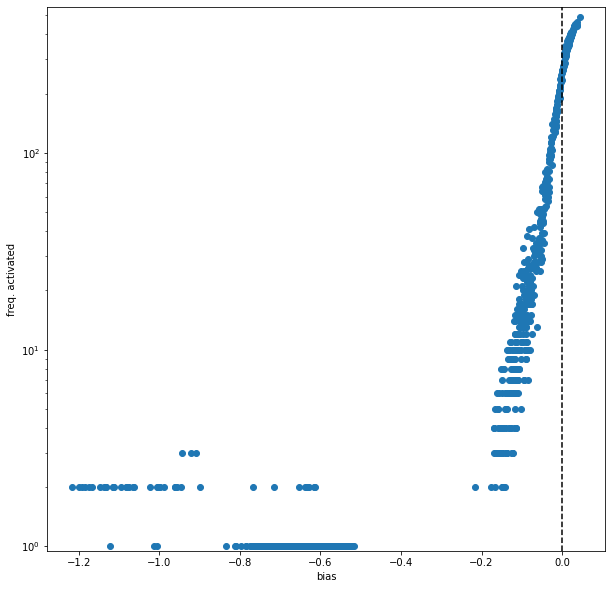

In [37]:
plt.figure(figsize=(10,10))
plt.scatter(sorted_bias, sorted_freq)
plt.plot([0,0], [0.95,550], 'k--')
plt.ylim(0.95, 550)
plt.yscale('log')
plt.xlabel('bias')
plt.ylabel('freq. activated')
plt.show()

In [38]:
print(len(where_pos_bias))

85


In [39]:
print(len(where_poly))

517


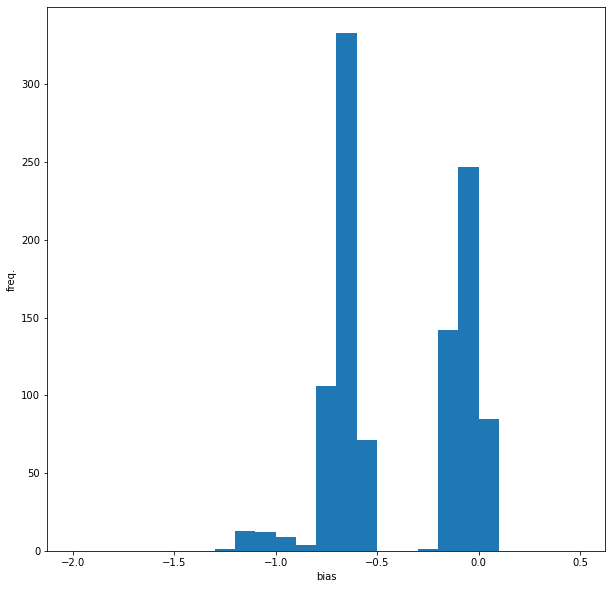

In [40]:
plt.figure(figsize=(10,10))
plt.hist([sorted_bias], bins=np.arange(-2,0.6,0.1))
plt.xlabel('bias')
plt.ylabel('freq.')
plt.show()

-1.0


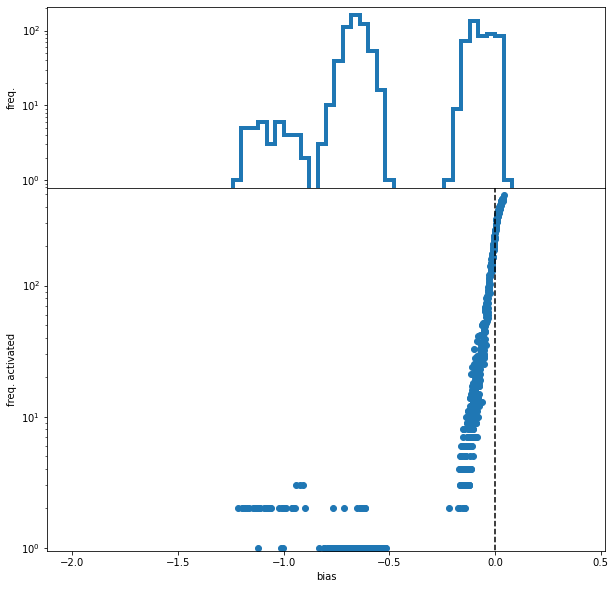

In [41]:
gs = GridSpec(2, 1, height_ratios=[0.5, 1], hspace=0)

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax1.get_shared_x_axes().join(ax1, ax2)

ax1.hist([sorted_bias], bins=np.arange(-2,0.44,0.04), histtype='step', lw=4)
# ax1.set_xlim(-2.0, 0.4)
# ax1.set_xlim(np.min(sorted_bias) - 0.1*np.abs(np.min(sorted_bias)), 0.4)
ax1.set_yscale('log')
ax1.set_ylabel('freq.')
ax1.set_xticks([])

print(np.rint(np.min(sorted_bias)))
ax2.scatter(sorted_bias, sorted_freq)
ax2.plot([0,0], [0.0,550], 'k--')
ax2.set_ylim(0.95, 550)
ax2.set_yscale('log')
ax2.set_xlabel('bias')
ax2.set_ylabel('freq. activated')

plt.show()

## ordered single feature activation with counts

In [42]:
sfa = sfa[inds]
# Sort the features to put the most-monosemantic neurons first
neuron_inds = []
for k in range(sfa.shape[1]): # Loop over features
    neuron_ind = np.argmax(sfa[:,k]) # Find the neuron this feature activates most-strongly.
    neuron_inds.append(neuron_ind)
inds = np.argsort(neuron_inds) # Sort the neuron indices
sfa = sfa[:,inds]

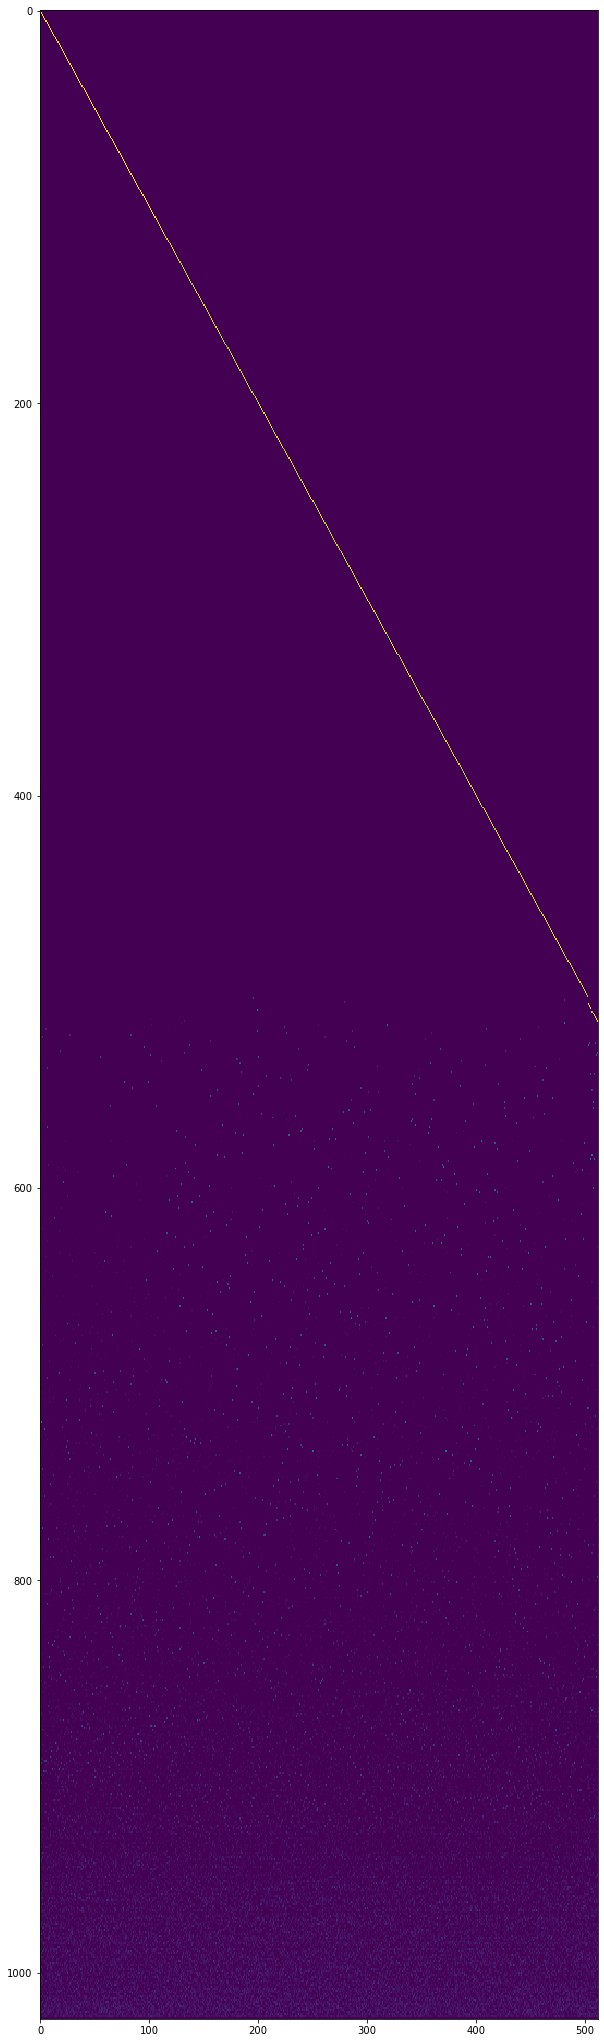

In [43]:
plt.figure(figsize=(10,100))
plt.imshow(sfa, interpolation='nearest', aspect=1.8, vmin=0, vmax=1.02)

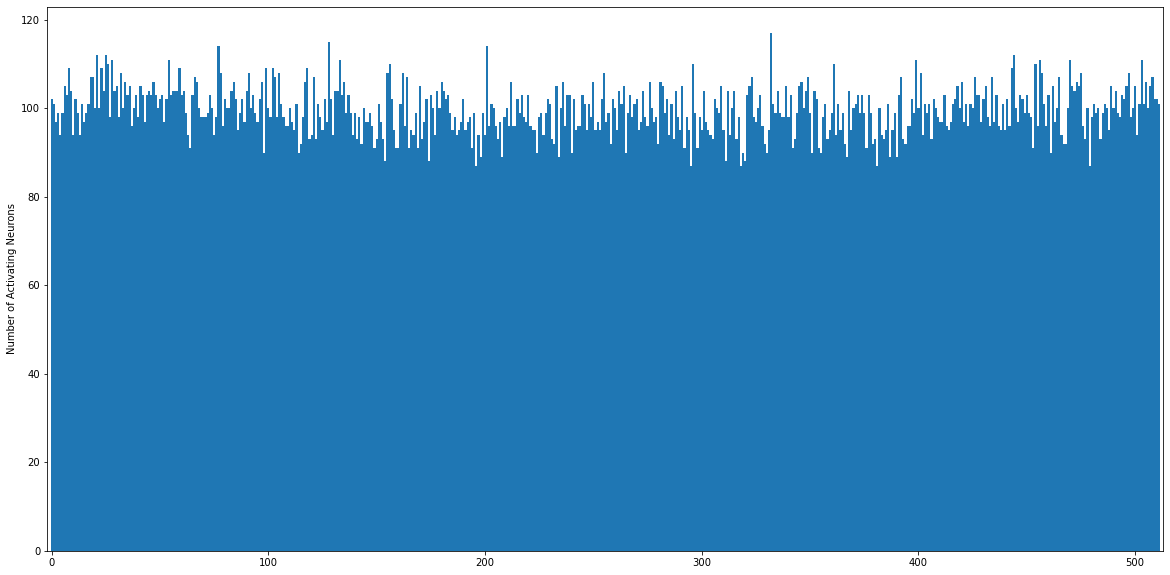

In [44]:
x_pos = range(0,512,1)
# print(np.sum(sfa[inds], axis=0).shape)
plt.figure(figsize=(20,10))
plt.bar(x_pos, np.sum(np.array(sfa>0.0, dtype='int'), axis=0), width=1)
# plt.yscale('log')
plt.ylabel('Number of Activating Neurons')
plt.xlim(-2,513)
plt.show()

In [45]:
print(np.sum(unit_sfa[inds], axis=0))

[58 48 54 57 51 57 52 57 51 53 55 57 58 55 47 55 56 56 55 58 49 43 57 57
 49 53 61 58 54 53 54 56 59 65 56 51 48 52 63 56 56 53 68 55 53 53 59 57
 59 55 57 55 50 56 58 56 58 54 57 55 50 58 60 59 56 57 54 54 54 55 59 56
 56 58 50 42 52 52 50 53 52 46 70 55 62 49 54 55 52 48 47 52 61 52 57 55
 56 53 55 56 53 52 56 55 56 48 51 53 59 50 52 50 62 50 60 57 61 57 61 53
 63 63 55 43 53 55 53 56 54 56 55 54 54 51 58 60 49 54 55 50 52 55 51 58
 63 52 54 56 52 50 50 53 54 62 55 53 45 56 54 62 59 50 49 50 54 58 47 61
 53 56 49 52 54 51 62 61 54 51 55 54 47 53 59 58 54 51 54 52 59 51 51 58
 59 57 52 60 48 52 51 58 44 55 54 59 54 60 47 57 53 44 50 50 63 54 53 57
 50 52 59 52 56 53 51 48 43 52 54 60 52 62 52 53 49 53 56 59 49 59 53 56
 52 54 54 59 63 54 53 53 59 53 53 55 62 57 59 51 54 64 59 54 54 56 56 52
 54 57 53 50 56 54 50 49 59 52 57 58 50 57 45 53 58 53 55 50 42 53 61 49
 58 58 58 55 53 52 56 55 51 52 53 53 57 47 54 58 54 50 52 57 49 54 46 55
 55 52 56 57 65 63 52 58 55 52 52 55 60 54 53 54 55

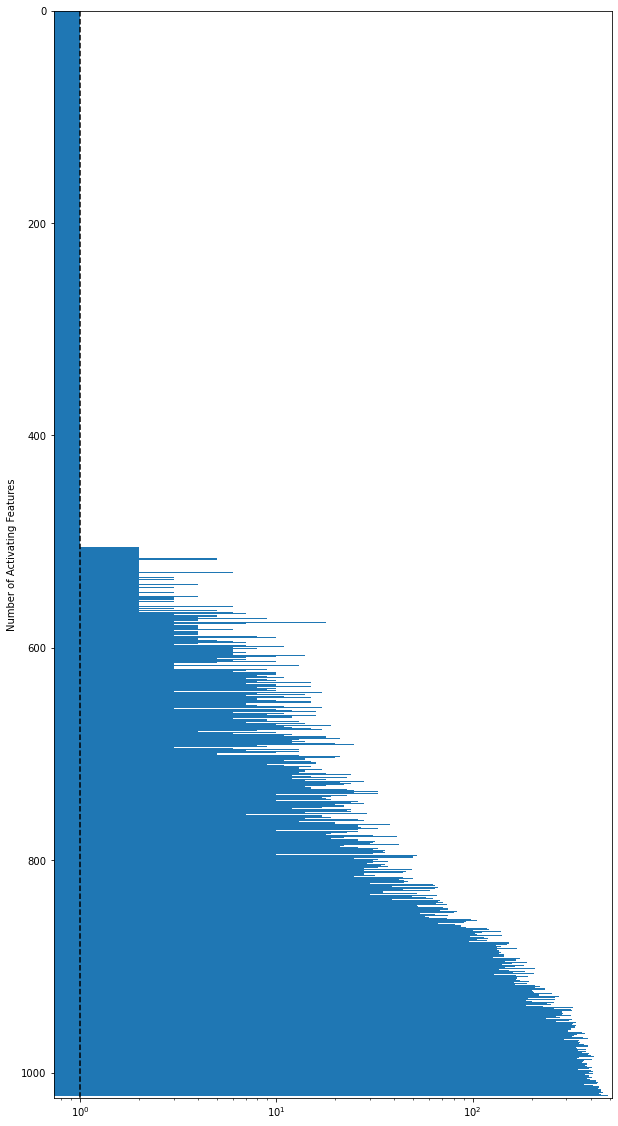

In [46]:
y_pos = range(0,1024,1)
# print(np.sum(sfa[inds], axis=0).shape)
plt.figure(figsize=(10,20))
plt.barh(y_pos, np.sum(np.array(sfa>0.0, dtype='int'), axis=-1), height=1)
plt.plot([1,1], [0,1024], 'k--')
plt.xscale('log')
plt.ylim(0,1024)
plt.xlim(xmax=512)
plt.gca().invert_yaxis()
plt.ylabel('Number of Activating Features')
plt.show()

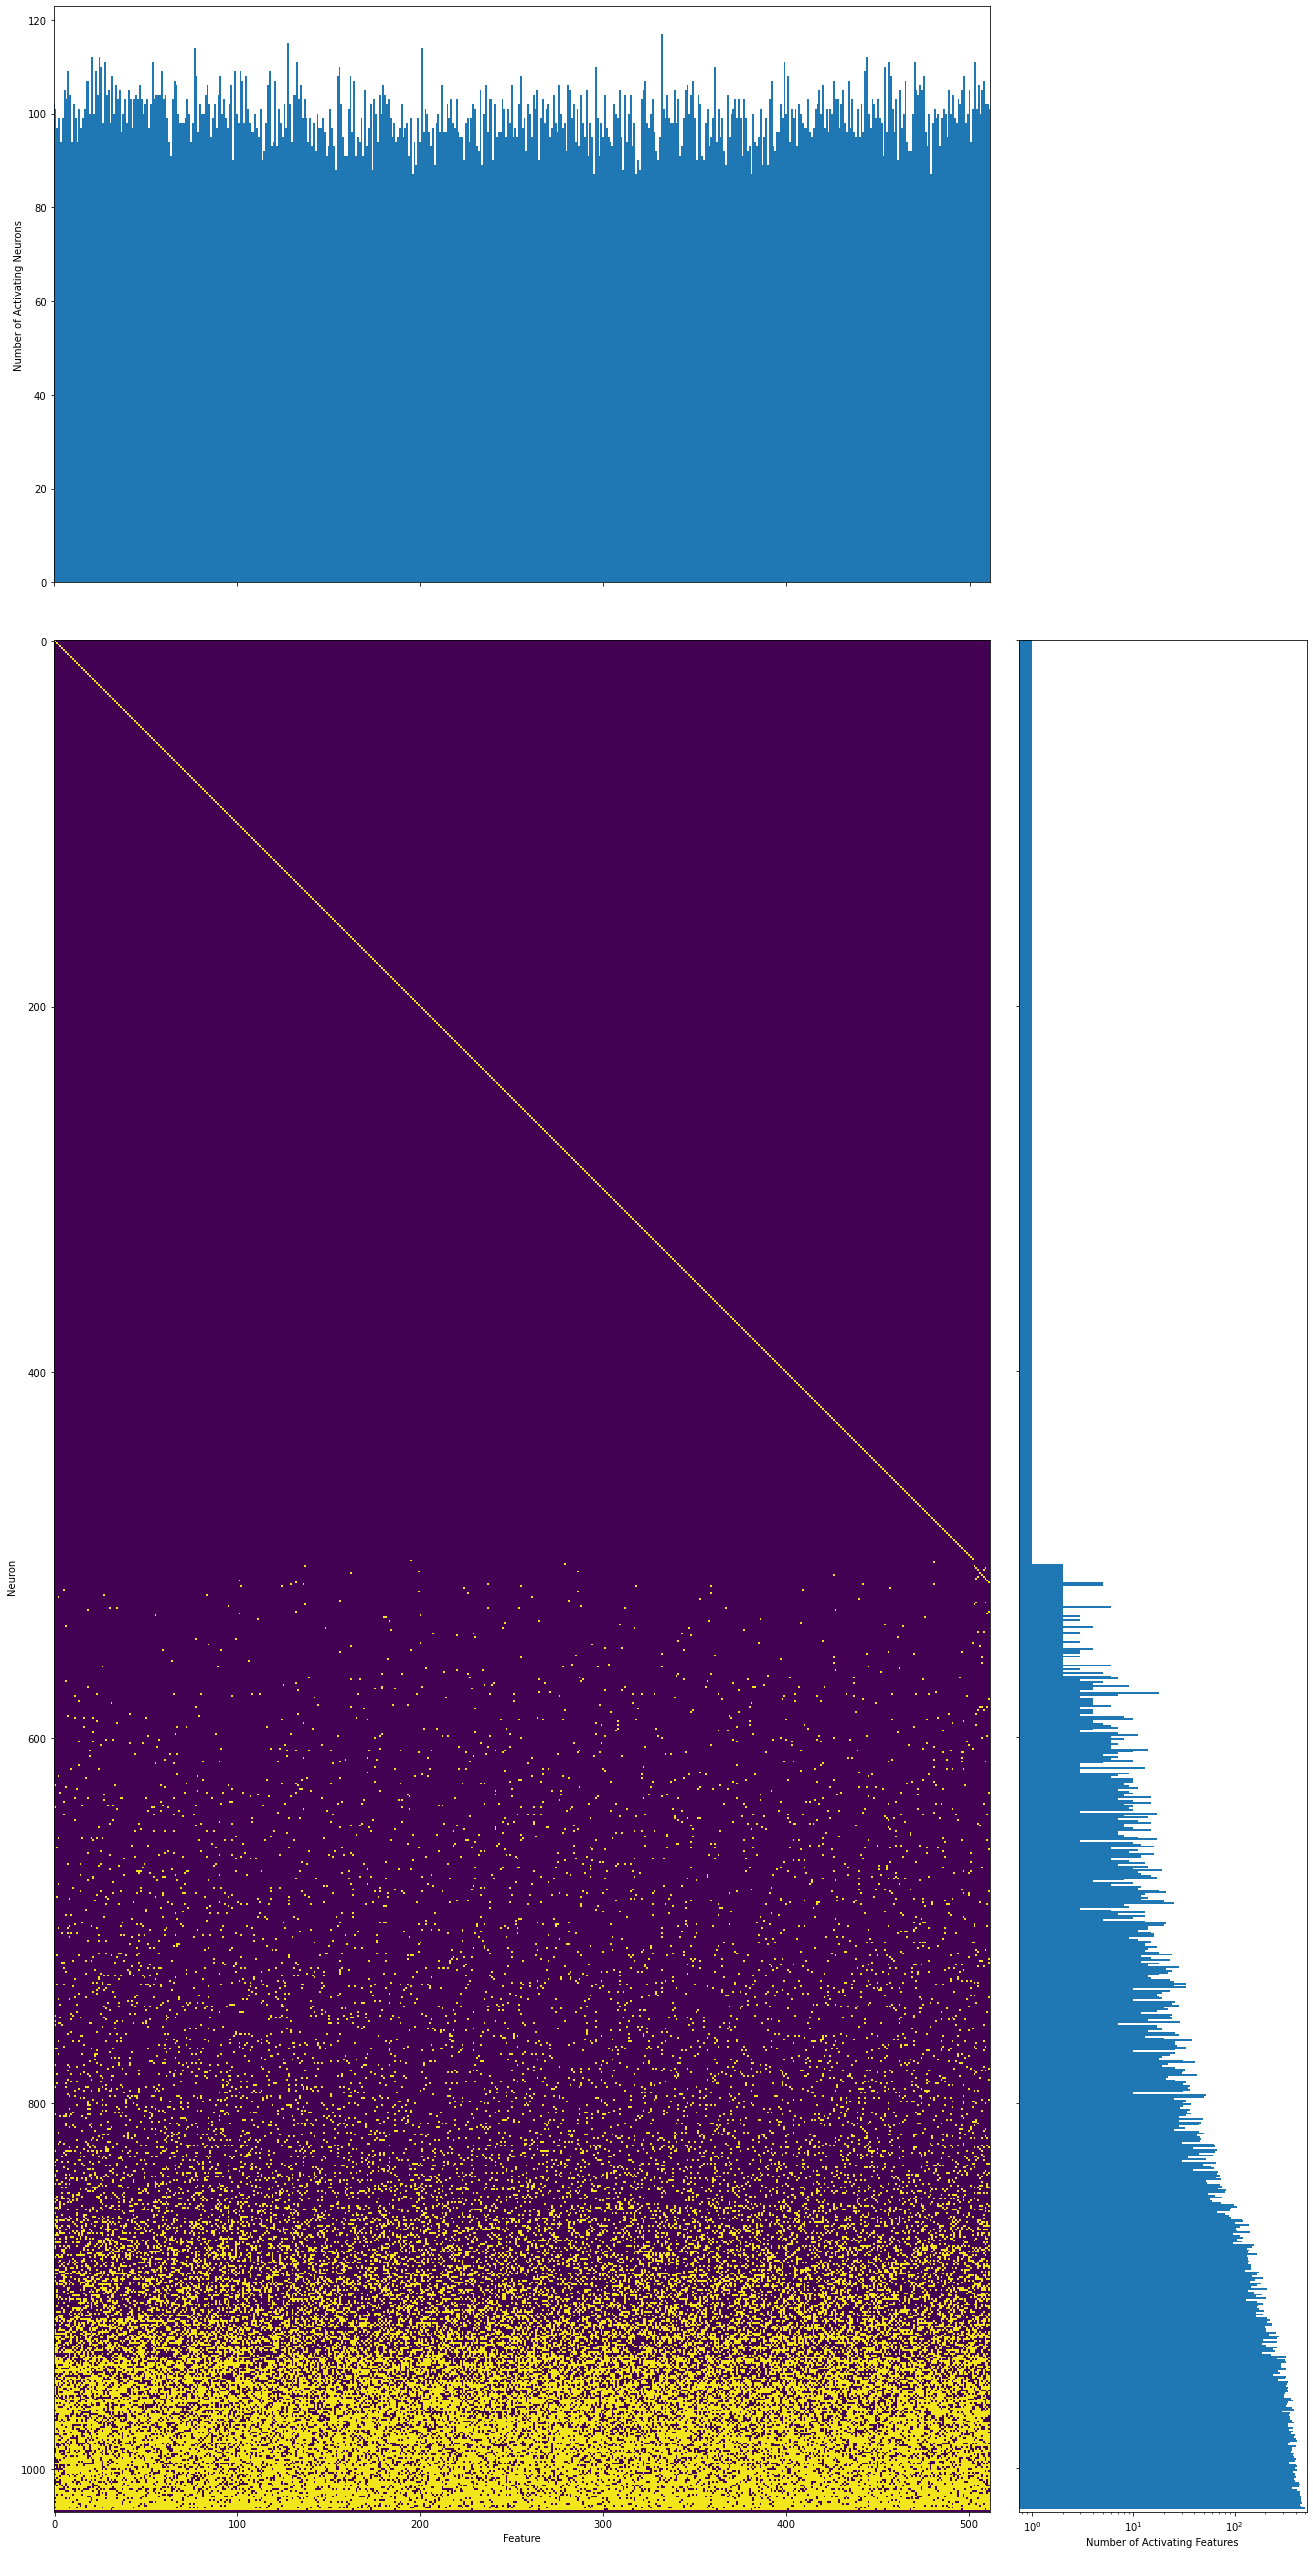

In [47]:
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_im = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

nullfmt = NullFormatter()         # no labels

plt.figure(figsize=(20,40))

axIm = plt.axes(rect_im)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

axIm.imshow(sfa>0.0, interpolation='nearest', vmin=0, vmax=1.02)
axIm.set_xlabel('Feature')
axIm.set_ylabel('Neuron')

axHistx.bar(x_pos, np.sum(np.array(sfa>0.0, dtype='int'), axis=0), width=1)
# axHistx.set_yscale('log')
axHistx.set_xlim(0,511)
# axHistx.set_ylim(0,1024)
axHistx.set_ylabel('Number of Activating Neurons')

axHisty.barh(y_pos, np.sum(np.array(sfa>0.0, dtype='int'), axis=-1), height=1)
axHisty.set_xscale('log')
axHisty.set_ylim(0,1024)
axHisty.set_xlim(xmax=512)
axHisty.set_xlabel('Number of Activating Features')
axHisty.invert_yaxis()

plt.show()

# Feature Function Derivation from monosemantic neurons

In [48]:
vs = torch.eye(N)
ins = torch.matmul(vs, fixed_embedder.T)
sfa = model[:2].forward(ins).T.detach().numpy()

In [49]:
sfa.shape

(1024, 512)

In [50]:
# Sort the neurons to put the most-monosemantic first
inds = np.argsort(-np.amax(sfa, axis=1) / (1e-10 + np.mean(sfa, axis=1)))

In [51]:
inds

array([511,  91, 293, ..., 249, 429, 357])

In [52]:
inds.shape

(1024,)

In [53]:
inds[0] # most monosemantic neuron index

511

In [54]:
np.argmax(sfa[inds[0],:]) # feature for which most monosemantic neuron fires most strongly

419

In [55]:
np.max(sfa[inds[0],:]) # strength of activation for the most strongly activating feature

1.0017796

In [56]:
np.max(sfa[inds[0],:]) / np.sum(sfa[inds[0],:]) # fraction of total activation the most strongly activating feature accounts for

1.0

In [57]:
# sfa = sfa[inds]
# # Sort the features to put the most-monosemantic neurons first
# neuron_inds = []
# for k in range(sfa.shape[1]): # Loop over features
#     neuron_ind = np.argmax(sfa[:,k]) # Find the neuron this feature activates most-strongly.
#     neuron_inds.append(neuron_ind)
# inds = np.argsort(neuron_inds) # Sort the neuron indices
# sfa = sfa[:,inds]

In [58]:
d['0.weight'].shape

torch.Size([1024, 64])

In [59]:
d['0.weight'][inds[0]]

tensor([-0.4369,  0.0972, -0.1530,  0.2465,  0.0966,  0.1182, -0.0651,  0.1334,
         0.2489,  0.1463, -0.0747, -0.3203, -0.0790, -0.3146, -0.2261,  0.1943,
         0.0093, -0.2487,  0.3615,  0.0622,  0.3362, -0.2017, -0.2169, -0.0089,
        -0.0382,  0.1128,  0.0358,  0.4948, -0.0883,  0.2322, -0.2762, -0.2857,
        -0.0866,  0.1116,  0.0503, -0.4362, -0.0764, -0.2139, -0.0092, -0.3543,
        -0.1042,  0.3235,  0.1394, -0.2530, -0.1485, -0.0491,  0.1743,  0.2099,
         0.0309, -0.0045,  0.4696,  0.1288, -0.2681,  0.1054, -0.1259,  0.1276,
        -0.3900, -0.1563, -0.1858, -0.0148, -0.1032, -0.0397,  0.1854, -0.2253])

In [60]:
d['0.bias'].shape

torch.Size([1024])

In [61]:
d['0.bias'][inds[0]]

tensor(-0.6643)

In [62]:
ins.shape

torch.Size([512, 64])

In [63]:
ins[np.argmax(sfa[inds[0],:]),:]

tensor([-0.1970,  0.0442, -0.0575,  0.1605,  0.1024,  0.0550, -0.0107,  0.0539,
         0.1476,  0.1410, -0.0356, -0.1742, -0.0091, -0.1761, -0.1164,  0.1225,
         0.0447, -0.1358,  0.2666, -0.0051,  0.1714, -0.1197, -0.1260, -0.0098,
        -0.0433,  0.0438, -0.0307,  0.3056, -0.0841,  0.1381, -0.1523, -0.1684,
        -0.0460,  0.0671, -0.0166, -0.2553, -0.0232, -0.1381, -0.0428, -0.1653,
        -0.0555,  0.2445,  0.0917, -0.1119, -0.1424,  0.0074,  0.1523,  0.0662,
         0.0495, -0.0441,  0.2333,  0.0826, -0.1719,  0.0139, -0.0830,  0.0915,
        -0.2038, -0.0555, -0.1169, -0.0139, -0.0485, -0.0523,  0.1264, -0.1047])

In [64]:
ins[np.argmax(sfa[inds[0],:]),:].shape

torch.Size([64])

In [65]:
np.dot(d['0.weight'][inds[0]].detach().numpy(), ins[np.argmax(sfa[inds[0],:]),:]) + d['0.bias'][inds[0]].detach().numpy()

1.0017793

In [66]:
d['2.weight'].shape

torch.Size([512, 1024])

In [67]:
x = np.zeros((1024,))

In [68]:
x.shape

(1024,)

In [69]:
x[inds[0]] = np.dot(d['0.weight'][inds[0]].detach().numpy(), ins[np.argmax(sfa[inds[0],:]),:]) + d['0.bias'][inds[0]].detach().numpy()
# x[inds[0]] = 1.0727885

In [70]:
x

array([0., 0., 0., ..., 0., 0., 0.])

In [71]:
p = np.dot(x, d['2.weight'].T)

In [72]:
p

array([ 3.83429604e-03,  7.05774601e-03,  6.33368286e-03,  4.36226271e-03,
        8.06804639e-03, -6.06949660e-03, -8.04732212e-03,  2.48062064e-03,
        4.95842881e-03,  1.32500874e-05, -7.42268988e-03, -2.37625524e-02,
       -1.18103660e-02, -1.81084023e-03,  6.12122052e-03,  1.39848263e-02,
        1.35333659e-02, -2.88430416e-03, -4.47907466e-02, -1.04882816e-02,
        6.57233393e-03,  7.37101260e-03,  1.89989671e-02, -2.70795751e-02,
       -1.04908734e-02, -1.23788194e-02, -9.15952114e-04, -5.75709301e-03,
        2.97441903e-03, -2.87125490e-02, -1.62563665e-03,  1.56706255e-02,
       -3.01088874e-02,  6.29278896e-03,  1.80638484e-04, -2.20683397e-02,
       -4.59108111e-03, -3.45747020e-03,  1.91119621e-02, -1.42105473e-03,
       -3.96053985e-02,  6.44954681e-03,  3.72100828e-03,  1.18158249e-02,
       -5.46773029e-03, -4.39888543e-03, -2.39267569e-02,  8.04853406e-03,
        9.49296949e-03, -4.13907111e-02,  5.80307398e-03,  1.84957189e-04,
       -1.99496715e-02, -

In [73]:
p.shape

(512,)

In [74]:
p[np.argmax(sfa[inds[0],:])]

0.766374897290234

In [75]:
sum((p - vs[np.argmax(sfa[inds[0],:]),:].detach().numpy())**2)

0.14815458161024028

In [76]:
o = model.forward(ins[np.argmax(sfa[inds[0],:]),:]).T.detach().numpy()

/tmp/ipykernel_47991/4045628994.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ./aten/src/ATen/native/TensorShape.cpp:3571.)
  o = model.forward(ins[np.argmax(sfa[inds[0],:]),:]).T.detach().numpy()


In [77]:
o

array([ 2.21691001e-03,  5.55603486e-03, -8.44637863e-04,  7.34143658e-03,
        3.51401977e-04, -5.40048443e-03,  3.58487107e-03,  7.48821441e-03,
       -4.79110843e-03, -5.12559852e-03,  3.39236576e-03, -6.32668473e-03,
        5.37473941e-03,  8.75147991e-03,  4.70576808e-03,  8.84530693e-03,
        6.26221299e-04,  6.63877465e-04, -6.04373310e-03,  4.12905123e-03,
        1.28026644e-03, -8.01630504e-03,  4.23670281e-04, -6.39061164e-03,
        4.69697127e-03, -4.95496090e-04, -2.81615742e-03, -4.11056099e-04,
        8.30022898e-03,  9.03385412e-03,  7.93896616e-03,  3.32981534e-03,
       -1.12610403e-03,  2.26083398e-03, -3.11673363e-03, -4.99525666e-03,
        9.28154308e-03,  2.30435166e-03,  3.73973604e-03,  8.49677436e-03,
       -3.97693831e-03, -1.93011621e-03,  1.28222257e-03,  3.93114425e-03,
        1.04852691e-02,  7.18773529e-03,  5.70523553e-04,  6.27631973e-03,
        2.55539082e-03, -6.26522209e-03,  8.55280086e-04,  6.48792461e-03,
       -4.78542130e-03,  

In [78]:
o.shape

(512,)

In [79]:
o[np.argmax(sfa[inds[0],:])]

0.9398004

In [80]:
sum((o - vs[np.argmax(sfa[inds[0],:]),:].detach().numpy())**2)

0.014950288058428768

# Monosemantic circuit study

For soft_dot_penalised_model trained on autoencoder task with a learning rate of 0.001, neuron 002 activates only for feature 468. Feature 468 only activates neuron 002.

The index for neuron 002 is 1.
The index for feature 468 is 467.

In [240]:
neuron = 1
feature = 467
# neuron = 467
# feature = 1

In [241]:
# model = 'model3'
model='soft_dot_penalised_model'
k = 1024 # size of nonlinear layer
log2_batch_size = 13
log2_training_steps = 18
sample_kind = 'equal'
init_bias = 0.0
nonlinearity = 'ReLU'
task = 'autoencoder'
decay = 0.0
eps = 0.015625
m = 64 # input dimensions
N = 512 # number of features
reg = 0.0
# lr = 0.001

step_size = .05

In [242]:
names = list([
    f"../my_models/{model}_{task}_{nonlinearity}_k_{k}_batch_{log2_batch_size}_steps_{log2_training_steps}_learning_rate_{lr}_sample_{sample_kind}_init_bias_{init_bias}_decay_{decay}_eps_{eps}_m_{m}_N_{N}_reg_{reg}.pt"
    for lr in [0.001,0.003,0.005,0.007,0.01,0.03]])

In [243]:
names[0]

'../my_models/soft_dot_penalised_model_autoencoder_ReLU_k_1024_batch_13_steps_18_learning_rate_0.001_sample_equal_init_bias_0.0_decay_0.0_eps_0.015625_m_64_N_512_reg_0.0.pt'

In [244]:
batch = torch.load(names[0], map_location=torch.device('cpu'))
fixed_embedder = batch['setup']['fixed_embedder']
d = batch['log2_spaced_models'][-1]
print(d['2.weight'].shape[0], N)
print(d['0.weight'].shape[1], m)
print(d['0.weight'].shape[0], k)
model = model_builder(d['2.weight'].shape[0], d['0.weight'].shape[1], d['0.weight'].shape[0], nonlinearity)
model.load_state_dict(batch['log2_spaced_models'][-1])
model.to('cpu')

512 512
64 64
1024 1024


Sequential(
  (0): Linear(in_features=64, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=512, bias=False)
)

In [245]:
vs = torch.eye(N)
ins = torch.matmul(vs, fixed_embedder.T)
sfa = model[:2].forward(ins).T.detach().numpy()
unit_sfa = np.array(sfa > 0.0, dtype='int')

In [246]:
where_mono = np.where(np.sum(unit_sfa, axis=-1) == 1)[0]
where_poly = np.where(np.sum(unit_sfa, axis=-1) > 1)[0]

mono_d = deepcopy(batch['log2_spaced_models'][-1])
print(mono_d['0.weight'][where_poly, :])
print(mono_d['0.weight'][where_poly, :].shape)

mono_d['0.weight'][where_poly, :] *= 0
mono_d['0.bias'][where_poly] *= 0
mono_model = model_builder(d['2.weight'].shape[0], d['0.weight'].shape[1], d['0.weight'].shape[0], nonlinearity)
mono_model.load_state_dict(mono_d)
mono_model.to('cpu')

poly_d = deepcopy(batch['log2_spaced_models'][-1])
print(poly_d['0.weight'][where_mono, :])
print(poly_d['0.weight'][where_mono, :].shape)
poly_d['0.weight'][where_mono, :] *= 0
poly_d['0.bias'][where_mono] *= 0
poly_model = model_builder(d['2.weight'].shape[0], d['0.weight'].shape[1], d['0.weight'].shape[0], nonlinearity)
poly_model.load_state_dict(poly_d)
poly_model.to('cpu')

tensor([], size=(0, 64))
torch.Size([0, 64])
tensor([[ 0.0368,  0.1879, -0.3572,  ..., -0.1784, -0.1027, -0.1068],
        [ 0.3028, -0.2855,  0.2794,  ..., -0.1424,  0.1662,  0.1694],
        [ 0.2554, -0.2144, -0.1369,  ...,  0.0267,  0.0518, -0.0926],
        ...,
        [-0.1347, -0.2707,  0.0438,  ..., -0.2173,  0.0534, -0.2118],
        [-0.1846, -0.0965, -0.0516,  ...,  0.0316,  0.1363,  0.0511],
        [-0.2085,  0.0223, -0.0266,  ...,  0.0460, -0.2507,  0.2010]])
torch.Size([513, 64])


Sequential(
  (0): Linear(in_features=64, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=512, bias=False)
)

In [247]:
full_os = []
mono_os = []
poly_os = []
for a in np.arange(0, 1 + step_size, step_size):
    vs = torch.eye(N) * a
    ins = torch.matmul(vs, fixed_embedder.T)
    full_os.append(model.forward(ins).T.detach().numpy())
    mono_os.append(mono_model.forward(ins).T.detach().numpy())
    poly_os.append(poly_model.forward(ins).T.detach().numpy())

In [248]:
full_os[-1][feature][feature]

0.9191318

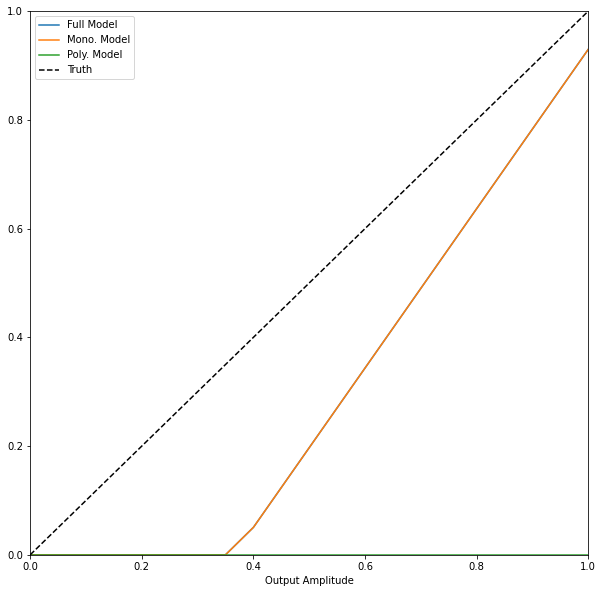

In [249]:
f = []
mono = []
poly = []
for i in range(len(mono_os)):
    f.append(full_os[i][neuron,neuron])
    mono.append(mono_os[i][neuron,neuron])
    poly.append(poly_os[i][neuron,neuron])

plt.figure(figsize=(10,10))
plt.plot(np.arange(0, 1 + step_size, step_size), f, '-', label='Full Model')
# plt.plot(np.arange(0, 1 + step_size, step_size), n, '-', label='Neg. Bias Model')
# plt.plot(np.arange(0, 1 + step_size, step_size), p, '-', label='Pos. Bias Model')
plt.plot(np.arange(0, 1 + step_size, step_size), mono, '-', label='Mono. Model')
plt.plot(np.arange(0, 1 + step_size, step_size), poly, '-', label='Poly. Model')
plt.plot([0,1], [0,1], 'k--', label='Truth')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Input Feature Amplitude')
plt.xlabel('Output Amplitude')
plt.legend()
plt.show()

In [250]:
mono_d.keys()

odict_keys(['0.weight', '0.bias', '2.weight'])

In [251]:
mono_d['0.weight'].shape, mono_d['0.bias'].shape, mono_d['2.weight'].shape

(torch.Size([1024, 64]), torch.Size([1024]), torch.Size([512, 1024]))

In [252]:
vs = torch.eye(N)
ins = torch.matmul(vs, fixed_embedder.T)

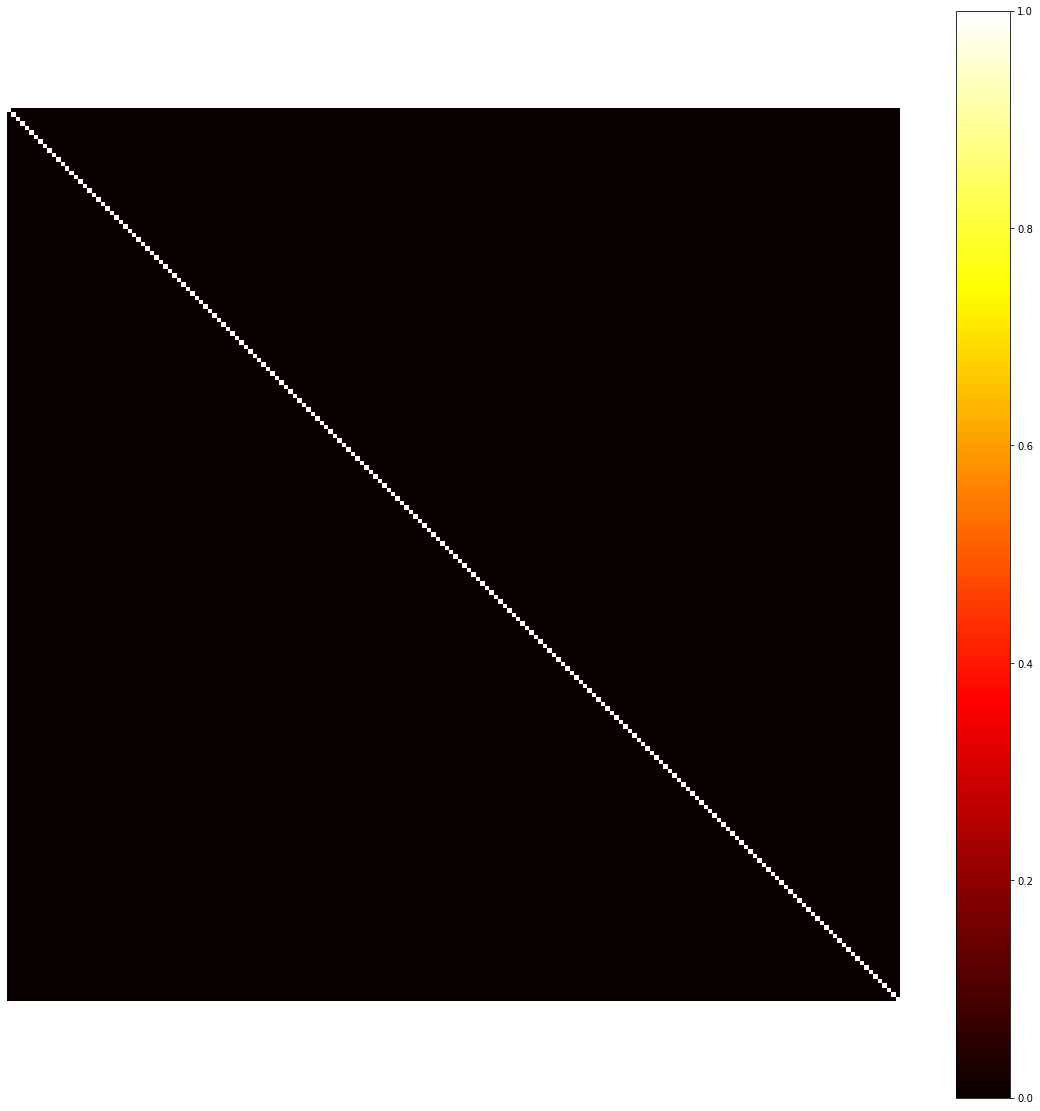

In [253]:
plt.figure(figsize=(20,20))
plt.imshow(vs[:200,:200], cmap='hot')
plt.axis('off')
plt.colorbar()

In [254]:
print(ins.shape)
print(mono_d['0.weight'].shape)

torch.Size([512, 64])
torch.Size([1024, 64])


In [255]:
print(ins[feature].shape)
print(mono_d['0.weight'][neuron].shape)

torch.Size([64])
torch.Size([64])


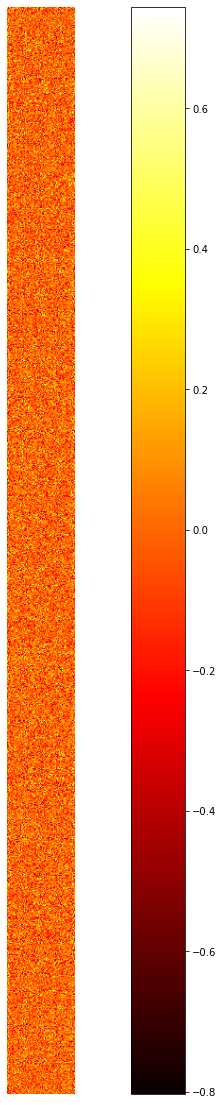

In [256]:
plt.figure(figsize=(20,20))
plt.imshow(mono_d['0.weight'], cmap='hot')
plt.axis('off')
plt.colorbar()

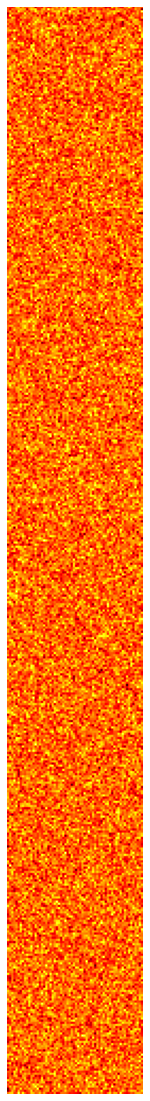

In [257]:
plt.figure(figsize=(20,20))
plt.imshow(ins, cmap='hot')
plt.axis('off')
plt.show()

In [258]:
np.sum(mono_d['0.weight'].detach().numpy(), axis=1)

array([ 1.1786716 , -0.21767658,  1.6042978 , ...,  0.10254185,
        0.9616336 , -0.9229782 ], dtype=float32)

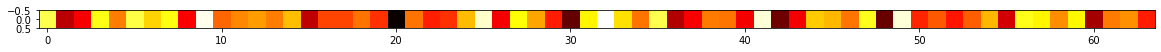

In [259]:
plt.figure(figsize=(20,20))
plt.imshow(mono_d['0.weight'][2][np.newaxis], cmap='hot')

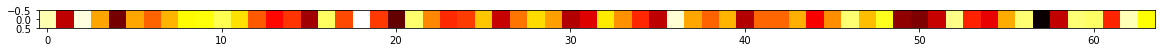

In [260]:
plt.figure(figsize=(20,20))
plt.imshow(ins[feature][np.newaxis], cmap='hot')

In [261]:
np.dot(mono_d['0.weight'], ins.T).shape

(1024, 512)

In [271]:
np.dot(mono_d['0.weight'][neuron], ins[feature])

1.3744867

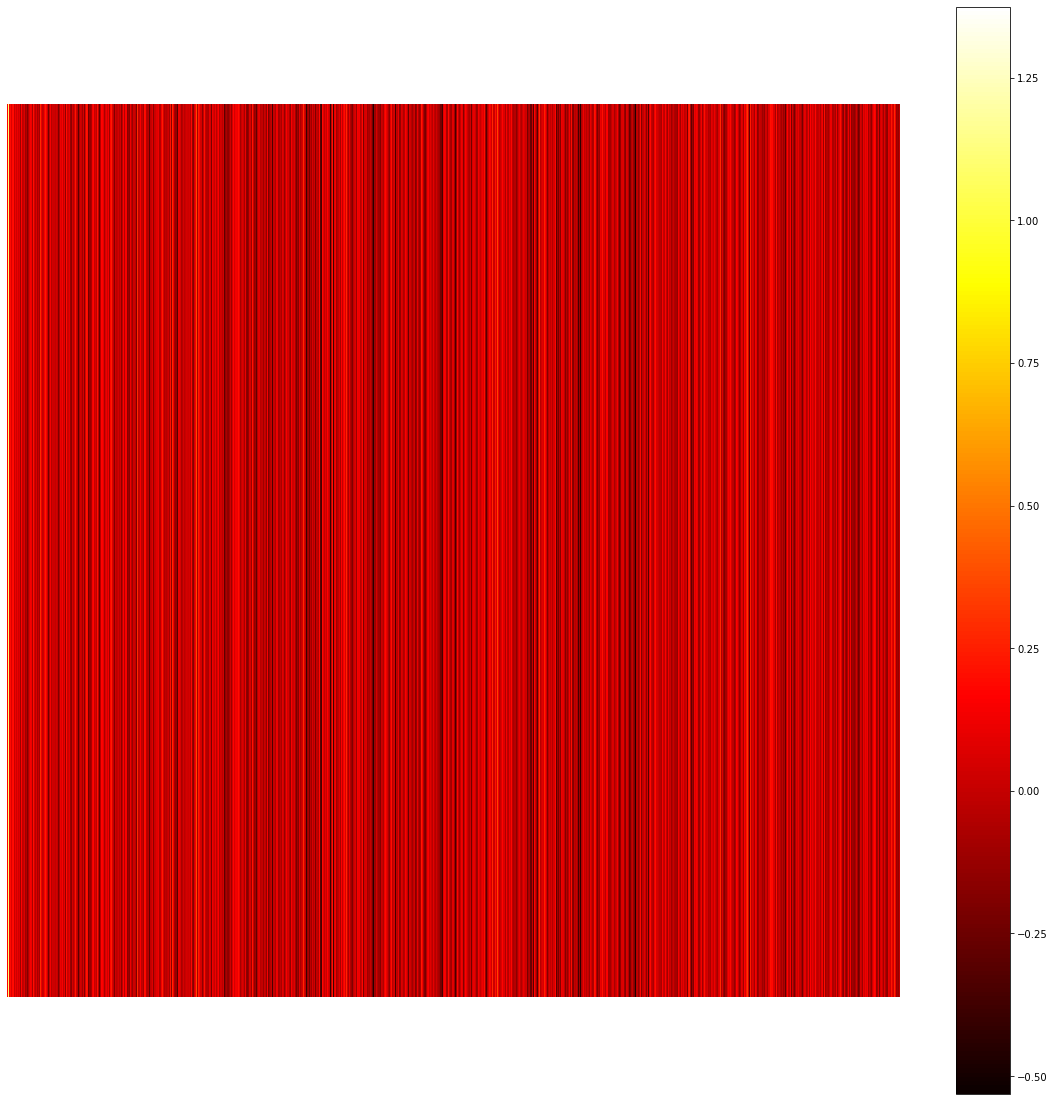

In [274]:
plt.figure(figsize=(20,20))
plt.imshow(np.repeat(np.dot(mono_d['0.weight'], ins[feature])[np.newaxis], repeats=1024, axis=0), cmap='hot')
plt.axis('off')
plt.colorbar()

In [275]:
np.dot(mono_d['0.weight'], ins[feature]).shape

(1024,)

In [276]:
mono_d['0.bias'].shape

torch.Size([1024])

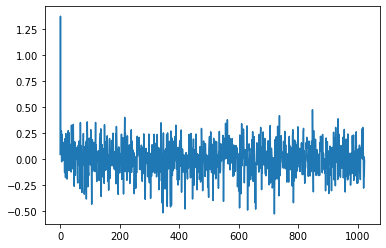

In [277]:
plt.plot(np.dot(mono_d['0.weight'], ins[feature]))

In [278]:
x = np.dot(mono_d['0.weight'], ins[feature]) + np.array(mono_d['0.bias'])

In [279]:
x.shape

(1024,)

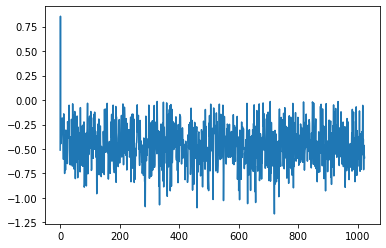

In [280]:
plt.plot(x)

In [281]:
np.argmax(x)

1

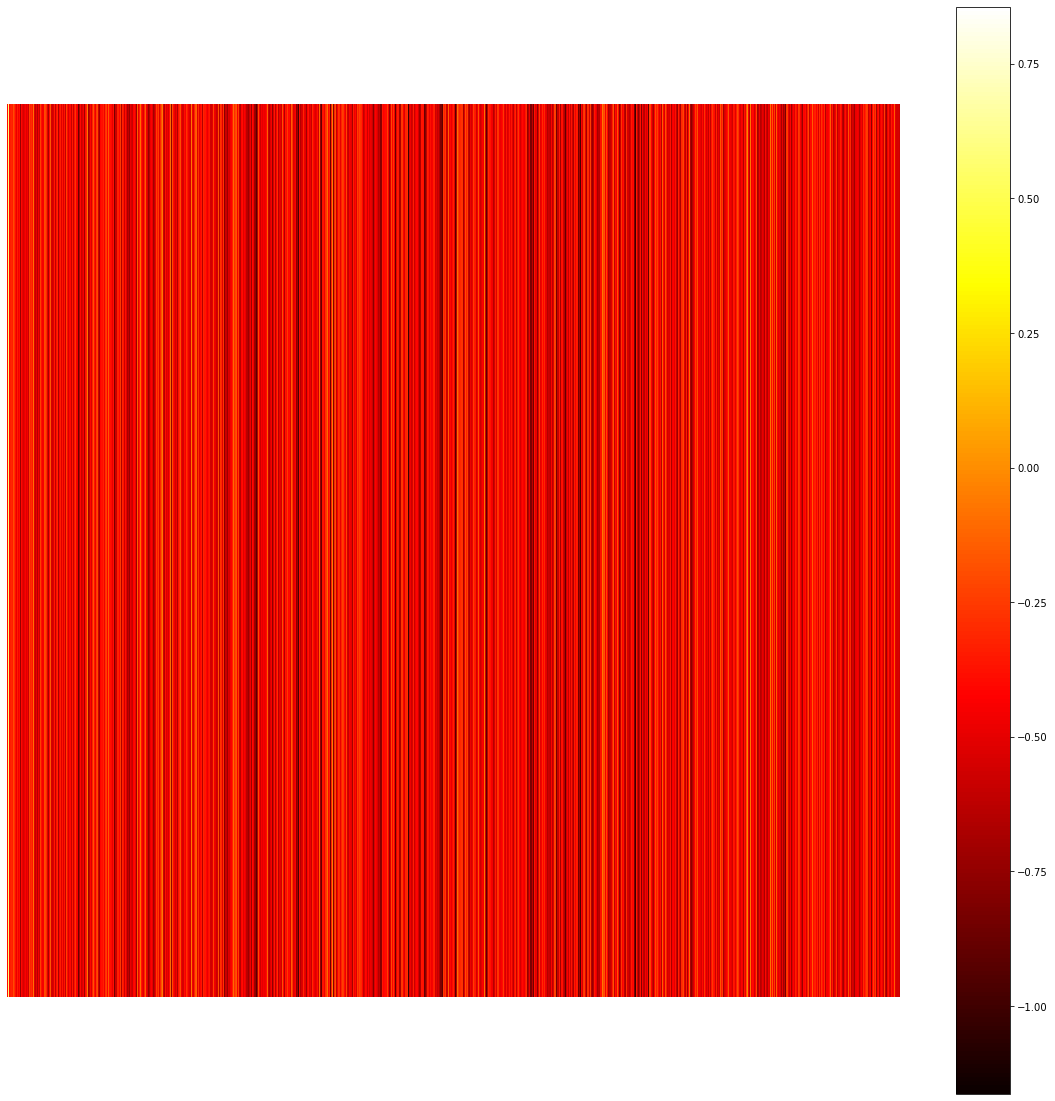

In [282]:
plt.figure(figsize=(20,20))
plt.imshow(np.repeat(x[np.newaxis], repeats=1024, axis=0), cmap='hot')
plt.axis('off')
plt.colorbar()

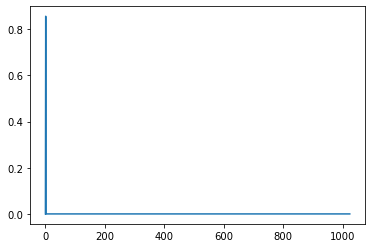

In [283]:
plt.plot(np.maximum(np.array(0), x))

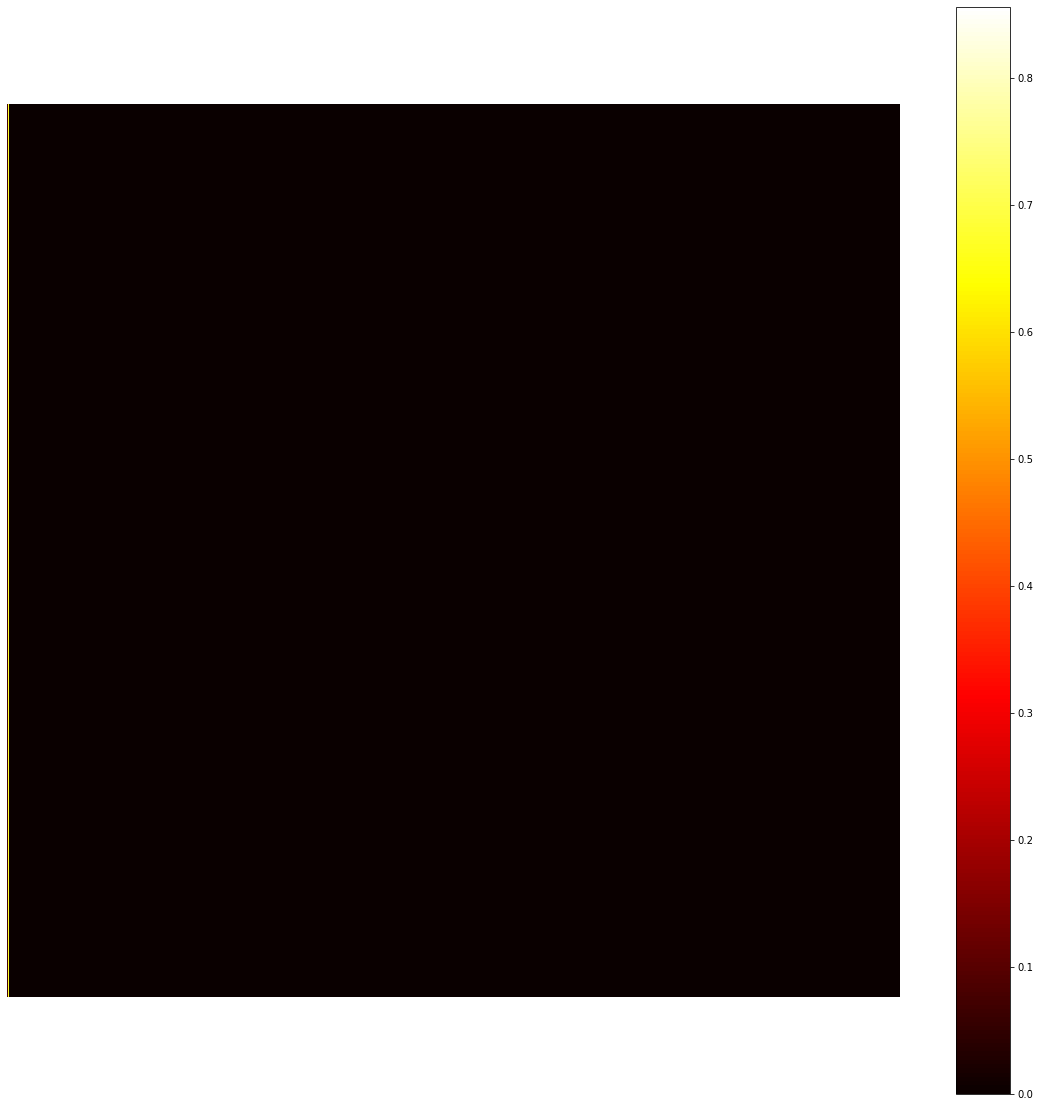

In [284]:
plt.figure(figsize=(20,20))
plt.imshow(np.repeat(np.maximum(np.array(0), x)[np.newaxis], repeats=1024, axis=0), cmap='hot')
plt.axis('off')
plt.colorbar()

In [285]:
np.maximum(np.array(0), x).shape, mono_d['2.weight'].T.shape

((1024,), torch.Size([1024, 512]))

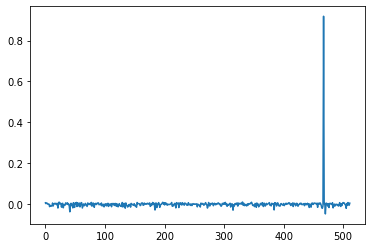

In [286]:
plt.plot(np.dot(np.maximum(np.array(0), x), mono_d['2.weight'].T))

In [287]:
np.argmax(np.dot(np.maximum(np.array(0), x), mono_d['2.weight'].T))

467

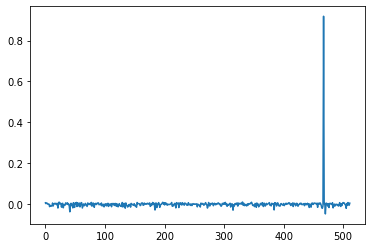

In [288]:
plt.plot(model.forward(ins[feature]).detach().numpy())

In [291]:
np.argmax(model.forward(ins).detach().numpy()[feature])

467

In [300]:
np.sum(np.dot(np.maximum(np.array(0), x), mono_d['2.weight'].T) - model.forward(ins).detach().numpy()[feature])

0.0

In [301]:
print(mono_d['0.weight'][:,neuron][np.newaxis].shape, ins[feature][np.newaxis].shape)

torch.Size([1, 1024]) torch.Size([1, 64])


In [302]:
np.max(np.dot(mono_d['0.weight'], ins[feature]))

1.3744867

In [303]:
np.argmax(np.dot(mono_d['0.weight'], ins[feature]))

1